# CCLM2 Nature Futures
-----------------
Produces regional climate statistics in Supplementary Data 3

In [1]:
import warnings
import os
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
%load_ext autoreload
%autoreload 2

# Custom settings and functions
from settings import *
from plotting import *
from func_calc import *
from func_stats import *
from func_plots import *

# Mute warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
set_plot_param()
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None, 'facecolor': '1'} # display figues as exported to PDF without 'tight'

# Settings

In [3]:
# Save to
os.makedirs('Tables', exist_ok=True)

dpath_stats = dpath_proc + 'climStats/'
os.makedirs(dpath_stats, exist_ok=True)

In [4]:
# Area for weighted mean
surf_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/surf.nc')
area = surf_ssp1.AREA

# Mask of potentially modified grid cells, based on EUNIS habitat mapping area (EU+)
eunis = xr.open_dataarray(dpath_proc + 'eunis_mask_repr.nc')

# Region mask
mask_2D = xr.open_dataarray(dpath_proc + 'regionmask_2D_Dou.nc')
mask_3D = xr.open_dataarray(dpath_proc + 'regionmask_3D_Dou.nc')

# Combine subregins and EU+ into one mask
eunis_mask = xr.where(eunis==1, True, False).rename('EU+') # convert to a boolean mask
eunis_mask = eunis_mask.expand_dims('region').assign_coords(region=['EU+']) # add region dimension
mask_3D_eu = xr.concat([eunis_mask, mask_3D], dim='region') # combine to joint mask

# Processing

In [5]:
vars = ['T_2M', 'TSOI_10CM', 'WIND_10M', 'PRECIP', 'TOTSOILWATER', 'SOILWATER_10CM', 'GPP']
frac = 0.01 # fraction for calculation of most affected areas, here 1%

## Annual

In [8]:
# Mean
file = 'cclm2_annual-climatology.nc'
ds_2015 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_hist/' + file)
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)

ds = xr.concat([ds_2015[vars],
                ds_ssp1[vars],
                ds_nfn[vars]-ds_ssp1[vars],
                ds_nfs[vars]-ds_ssp1[vars],
                ds_nac[vars]-ds_ssp1[vars],
                ds_ssp1[vars]-ds_2015[vars]], dim='case').assign_coords({'case': ('case', ['recent','ssp1','nfn-ssp1','nfs-ssp1','nac-ssp1','ssp1-recent'])})

# TXx (annual maximum value of daily max temperature)
file = 'cosmo_T2m-max-climatology.nc'
dx_2015 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_hist/' + file)
dx_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)
dx_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)
dx_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)
dx_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)

varmax = ['TMAX_2M']
dx = xr.concat([dx_2015[varmax],
                dx_ssp1[varmax],
                dx_nfn[varmax]-dx_ssp1[varmax],
                dx_nfs[varmax]-dx_ssp1[varmax],
                dx_nac[varmax]-dx_ssp1[varmax],
                dx_ssp1[varmax]-dx_2015[varmax]],dim='case').assign_coords({'case': ('case', ['recent','ssp1','nfn-ssp1','nfs-ssp1','nac-ssp1','ssp1-recent'])})
dx = dx.rename({'TMAX_2M': 'TXx'})

# Combine annual and TXx
ds = xr.merge([ds, dx]).where(eunis==1)

# EU+ and regions
ds_reg = ds.weighted(mask_3D_eu*area.fillna(0)).mean(['lat','lon'])

# 1% min and max area within EU+ (weighted quantile); ca 120,000 km2 (1400-4000 grid cells)
min_mask = ds.where(ds<ds.weighted(area.fillna(0)).quantile(frac, dim=['lat','lon']).drop_vars('quantile'))
min_mask = xr.where(min_mask.notnull(), 1, 0)
max_mask = ds.where(ds>ds.weighted(area.fillna(0)).quantile(1-frac, dim=['lat','lon']).drop_vars('quantile'))
max_mask = xr.where(max_mask.notnull(), 1, 0)
# Min and max affected in each case
ds_min = ds.where(min_mask==1).mean(['lat','lon']).expand_dims(dim={'region': ['Min']})
ds_max = ds.where(max_mask==1).mean(['lat','lon']).expand_dims(dim={'region': ['Max']})
# Min and max area in SSP1, e.g., hottest areas
ds_min_ssp1 = ds.where(min_mask.sel(case='ssp1',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Min SSP1']})
ds_max_ssp1 = ds.where(max_mask.sel(case='ssp1',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Max SSP1']})
# Min and max changing area in SSP1-Recent, e.g., most heating areas
ds_min_change = ds.where(min_mask.sel(case='ssp1-recent',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Min SSP1−Recent']})
ds_max_change = ds.where(max_mask.sel(case='ssp1-recent',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Max SSP1−Recent']})

max_mask_ann = max_mask.expand_dims(dim={'season': ['Annual']}) # save to avoid it getting overwritten
min_mask_ann = max_mask.expand_dims(dim={'season': ['Annual']}) # save to avoid it getting overwritten

mean_ann = xr.concat([ds_reg, ds_min, ds_max, ds_min_ssp1, ds_max_ssp1, ds_min_change, ds_max_change], dim='region')

In [9]:
# Standard deviation / CI and significance
# Difference SSP1-Recent cannot be calculated because of different years (but do independent samples sig test)
file = 'cclm2_annual-series.nc'
ds_2015 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_hist/' + file)
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)

ds = xr.concat([ds_2015[vars],
                ds_ssp1[vars],
                ds_nfn[vars]-ds_ssp1[vars],
                ds_nfs[vars]-ds_ssp1[vars],
                ds_nac[vars]-ds_ssp1[vars]], dim='case').assign_coords({'case': ('case', ['recent','ssp1','nfn-ssp1','nfs-ssp1','nac-ssp1'])})

# TXx (annual maximum value of daily max temperature)
# Process separately because it does not have seasons
file = 'cosmo_T2m-max-series.nc'
dx_2015 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_hist/' + file)
dx_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)
dx_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)
dx_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)
dx_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)

varmax = ['TMAX_2M']
dx = xr.concat([dx_2015[varmax],
                dx_ssp1[varmax],
                dx_nfn[varmax]-dx_ssp1[varmax],
                dx_nfs[varmax]-dx_ssp1[varmax],
                dx_nac[varmax]-dx_ssp1[varmax]],dim='case').assign_coords({'case': ('case', ['recent','ssp1','nfn-ssp1','nfs-ssp1','nac-ssp1'])})
dx = dx.rename({'TMAX_2M': 'TXx'})

# Combine annual and TXx
ds = xr.merge([ds, dx]).where(eunis==1)
ds_ann_series = ds.copy(deep=True) # save to avoid overwriting

# Combine for EU+, regions, and Min/Max affected
ds_reg = ds.weighted(mask_3D_eu*area.fillna(0)).mean(['lat','lon'])
# Min and max affected in each case
ds_min = ds.where(min_mask==1).mean(['lat','lon']).expand_dims(dim={'region': ['Min']})
ds_max = ds.where(max_mask==1).mean(['lat','lon']).expand_dims(dim={'region': ['Max']})
# Min and max area in SSP1, e.g., hottest areas
ds_min_ssp1 = ds.where(min_mask.sel(case='ssp1',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Min SSP1']})
ds_max_ssp1 = ds.where(max_mask.sel(case='ssp1',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Max SSP1']})
# Min and max changing area in SSP1-Recent, e.g., most heating areas
ds_min_change = ds.where(min_mask.sel(case='ssp1-recent',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Min SSP1−Recent']})
ds_max_change = ds.where(max_mask.sel(case='ssp1-recent',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Max SSP1−Recent']})
ds_agg = xr.concat([ds_reg, ds_min, ds_max, ds_min_ssp1, ds_max_ssp1, ds_min_change, ds_max_change], dim='region')

std_ann = ds_agg.std('year')
ds_ann = ds_agg.copy(deep=True) # copy to avoid overwriting

In [10]:
# Total GPP decrease over EU+
(mean_ann['GPP'].sel(region='EU+')*365*area.where(eunis==1).sum()*10**6 / 10**12).to_pandas().round(0) # convert g/m2/day to Tg/year over EU+ (area is in km2)

case
recent         4183.0
ssp1           3973.0
nfn-ssp1        -37.0
nfs-ssp1         -8.0
nac-ssp1       -442.0
ssp1-recent    -211.0
dtype: float64

In [11]:
(std_ann['GPP'].sel(region='EU+')*365*area.where(eunis==1).sum()*10**6 / 10**12).to_pandas().round(0) # convert g/m2/day to Tg/year over EU+ (area is in km2)

case
recent      90.0
ssp1        92.0
nfn-ssp1    17.0
nfs-ssp1    17.0
nac-ssp1    17.0
dtype: float64

In [12]:
# Total GPP decrease relative to SSP1 (%)
GPP_abs = mean_ann['GPP'].sel(region='EU+').to_pandas()
(100*GPP_abs/GPP_abs[1]).round(1)

case
recent         105.3
ssp1           100.0
nfn-ssp1        -0.9
nfs-ssp1        -0.2
nac-ssp1       -11.1
ssp1-recent     -5.3
dtype: float64

In [13]:
GPP_abs = ds_reg['GPP'].sel(region='EU+', drop=True)
(100*GPP_abs/GPP_abs.sel(case='ssp1', drop=True)).std('year').to_pandas().round(2)

case
recent       NaN
ssp1        0.00
nfn-ssp1    0.41
nfs-ssp1    0.44
nac-ssp1    0.36
dtype: float64

## Seasonal

In [14]:
# Mean
file = 'cclm2_seasonal-climatology.nc'
ds_2015 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_hist/' + file)
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)

ds = xr.concat([ds_2015[vars],
                ds_ssp1[vars],
                ds_nfn[vars]-ds_ssp1[vars],
                ds_nfs[vars]-ds_ssp1[vars],
                ds_nac[vars]-ds_ssp1[vars],
                ds_ssp1[vars]-ds_2015[vars]], dim='case').assign_coords({'case': ('case', ['recent','ssp1','nfn-ssp1','nfs-ssp1','nac-ssp1','ssp1-recent'])})
ds = ds.where(eunis==1)

# EU+ and regions
ds_reg = ds.weighted(mask_3D_eu*area.fillna(0)).mean(['lat','lon'])

# 1% min and max affected area (weighted quantile); ca 120,000 km2 (1400-4000 grid cells)
min_mask = ds.where(ds<ds.weighted(area.fillna(0)).quantile(frac, dim=['lat','lon']).drop_vars('quantile'))
min_mask = xr.where(min_mask.notnull(), 1, 0)
max_mask = ds.where(ds>ds.weighted(area.fillna(0)).quantile(1-frac, dim=['lat','lon']).drop_vars('quantile'))
max_mask = xr.where(max_mask.notnull(), 1, 0)
# Min and max affected in each case
ds_min = ds.where(min_mask==1).mean(['lat','lon']).expand_dims(dim={'region': ['Min']})
ds_max = ds.where(max_mask==1).mean(['lat','lon']).expand_dims(dim={'region': ['Max']})
# Min and max area in SSP1, e.g., hottest areas
ds_min_ssp1 = ds.where(min_mask.sel(case='ssp1',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Min SSP1']})
ds_max_ssp1 = ds.where(max_mask.sel(case='ssp1',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Max SSP1']})
# Min and max changing area in SSP1-Recent, e.g., most heating areas
ds_min_change = ds.where(min_mask.sel(case='ssp1-recent',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Min SSP1−Recent']})
ds_max_change = ds.where(max_mask.sel(case='ssp1-recent',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Max SSP1−Recent']})

mean = xr.concat([ds_reg, ds_min, ds_max, ds_min_ssp1, ds_max_ssp1, ds_min_change, ds_max_change], dim='region')

In [15]:
# Standard deviation and significance
# SSP1-Recent cannot be calculated because of different years
file = 'cclm2_seasonal-series.nc'
ds_2015 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_hist/' + file)
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)

ds = xr.concat([ds_2015[vars],
                ds_ssp1[vars],
                ds_nfn[vars]-ds_ssp1[vars],
                ds_nfs[vars]-ds_ssp1[vars],
                ds_nac[vars]-ds_ssp1[vars]], dim='case').assign_coords({'case': ('case', ['recent','ssp1','nfn-ssp1','nfs-ssp1','nac-ssp1'])})
ds = ds.where(eunis==1)
ds_seas_series = ds.copy(deep=True) # save to avoid overwriting

# Combine series for EU+, regions, and Min/Max affected
ds_reg = ds.weighted(mask_3D_eu*area.fillna(0)).mean(['lat','lon'])
# Min and max affected in each case
ds_min = ds.groupby('time.season').where(min_mask==1).mean(['lat','lon']).expand_dims(dim={'region': ['Min']})
ds_max = ds.groupby('time.season').where(max_mask==1).mean(['lat','lon']).expand_dims(dim={'region': ['Max']})
# Min and max area in SSP1, e.g., hottest areas
ds_min_ssp1 = ds.groupby('time.season').where(min_mask.sel(case='ssp1',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Min SSP1']})
ds_max_ssp1 = ds.groupby('time.season').where(max_mask.sel(case='ssp1',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Max SSP1']})
# Min and max changing area in SSP1-Recent, e.g., most heating areas
ds_min_change = ds.groupby('time.season').where(min_mask.sel(case='ssp1-recent',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Min SSP1−Recent']})
ds_max_change = ds.groupby('time.season').where(max_mask.sel(case='ssp1-recent',drop=True)==1).mean(['lat','lon']).expand_dims(dim={'region': ['Max SSP1−Recent']})
ds_agg = xr.concat([ds_reg, ds_min, ds_max, ds_min_ssp1, ds_max_ssp1, ds_min_change, ds_max_change], dim='region')

std = ds_agg.groupby('time.season').std('time')

In [16]:
# Merge annual and seasonal results and save
mean = xr.merge([mean_ann.expand_dims(dim={'season': ['Annual']}), mean])
std = xr.merge([std_ann.expand_dims(dim={'season': ['Annual']}), std])
mean.to_netcdf(dpath_stats + f'climStats_mean_{frac}.nc')
std.to_netcdf(dpath_stats + f'climStats_std_{frac}.nc')

min_mask = xr.merge([min_mask_ann, min_mask])
max_mask = xr.merge([max_mask_ann, max_mask])
min_mask = min_mask.where(min_mask>0) # replace 0 by nan for plotting
max_mask = max_mask.where(max_mask>0)
min_mask.to_netcdf(dpath_stats + f'climMask_min_{frac}.nc')
max_mask.to_netcdf(dpath_stats + f'climMask_max_{frac}.nc')

## Joint significance testing (with FDR adjustment)

In [17]:
# FDR per variable & case (across regions × seasons)
paired = ['nfn-ssp1', 'nfs-ssp1', 'nac-ssp1']   # Wilcoxon on differences
independent = [("ssp1", "recent")]              # M–W U on raw cases
sig_ann = xr_significance(ds_ann, test_dim="year", split_dim=None, paired_samples=paired, independent_samples=independent, multitest=True)
sig = xr_significance(ds_agg, test_dim="time", split_dim="season", paired_samples=paired, independent_samples=independent, multitest=True)

# Merge annual and seasonal results
sig = xr.merge([sig_ann.expand_dims(dim={'season': ['Annual']}), sig])

# Rearrange variables and dimensions
da = xr.concat([sig["statistic"], sig["p"], sig["effect_size"]], dim="stat").assign_coords(stat=["statistic", "p", "effect_size"])
sig = da.to_dataset(dim="variable")
sig.to_netcdf(dpath_stats + f'climStats_sig_{frac}.nc')

# Table with significance (Supplementary Data 3)

In [18]:
frac = 0.01 # 1% most affected
mean = xr.open_dataset(dpath_stats + f'climStats_mean_{frac}.nc')
std = xr.open_dataset(dpath_stats + f'climStats_std_{frac}.nc')
sig = xr.open_dataset(dpath_stats + f'climStats_sig_{frac}.nc')

# Summarize statistics: pulls statistic, p, and effect_size from the stat dimension
sig = summarize_stat_dim(sig, stat_dim="stat", blank_cases=["recent", "ssp1"], nan_label="")

In [19]:
vars = ['TXx', 'T_2M', 'TSOI_10CM', 'WIND_10M', 'PRECIP', 'SOILWATER_10CM', 'GPP'] # 'TOTSOILWATER'
row_headers = ['Max air temperature at 2m (TXx, °C)', 'Air temperature at 2m (°C)', 'Soil temperature 0-10cm (°C)', 'Wind speed at 10m (m s−¹)',
               'Precipitation (mm day−¹)', 'Soil moisture 0-10cm (mm)', 'Gross primary production (GPP, g C m−² day−¹)']
rows = dict(zip(vars, row_headers))
columns = {'recent': 'Recent', 'ssp1': 'SSP1', 'nfn-ssp1': 'NfN−SSP1', 'nfs-ssp1': 'NfS−SSP1', 'nac-ssp1': 'NaC−SSP1', 'ssp1-recent': 'SSP1−Recent'}

In [20]:
# Table
with pd.ExcelWriter(f'Tables/SuppData3_statistics_{frac}.xlsx', mode='w') as writer:
    for seas in ['Annual', 'DJF', 'MAM', 'JJA', 'SON']:
        table_mean = mean.to_array().to_dataset('case').sel(season=seas, drop=True).to_dataframe()
        table_std = std.to_array().to_dataset('case').sel(season=seas, drop=True).to_dataframe()
        table_sig = sig.to_array().to_dataset('case').sel(season=seas, drop=True).to_dataframe()
        table_sig = table_sig.reindex(columns=table_mean.columns, fill_value="")
        table_std['ssp1-recent'] = np.nan # set to nothing because we only have the multiyear mean
        table_print = table_mean.applymap(lambda x: '{0:.2f}'.format(x)) + " ± " + table_std.applymap(lambda x: '{0:.2f}'.format(x)) + " " + table_sig
        table_print['ssp1-recent'] = table_print['ssp1-recent'].str.split(" ± nan", expand=True)[0] + table_print['ssp1-recent'].str.split(" ± nan", expand=True)[1] # remove std
        table_print = table_print.reindex_like(table_mean)
        table_print = table_print.reindex(['TXx', 'T_2M', 'TSOI_10CM', 'WIND_10M', 'PRECIP', 'SOILWATER_10CM', 'GPP'], level=0)
        table_print = table_print.rename(index=rows)
        table_print = table_print.rename(index={'Min': f'Min affected {int(frac*100)}%', 'Max': f'Max affected {int(frac*100)}%'}, level=1)
        table_print = table_print.rename(columns=columns)
        if seas in ['DJF', 'MAM', 'JJA', 'SON']:
            table_print = table_print.drop('Max air temperature at 2m (TXx, °C)', level=0) # annual max not relevant
        table_print.to_excel(writer, sheet_name=seas)

# Grid cell level strongest effects in any year

In [23]:
# Annual
ds_ann = ds_ann_series.sel(case=slice('nfn-ssp1','nac-ssp1'))
df = xr.concat([ds_ann.min(['lat','lon','year']), ds_ann.max(['lat','lon','year'])], dim='func').assign_coords({'func': ('func', ['Min','Max'])}).to_dataframe()
df = df.stack().reset_index().rename(columns={'level_2': 'variable'})
df = df.pivot(index=['variable','func'], columns='case', values=0)[['nfn-ssp1','nfs-ssp1','nac-ssp1']]
df = df.round(2)
df = df.reindex(['TXx', 'T_2M', 'TSOI_10CM', 'WIND_10M', 'PRECIP', 'SOILWATER_10CM', 'GPP'], level=0).reindex(['Min', 'Max'], level=1)
df = df.rename(index=rows).rename(columns=columns)
df_ann = df.copy(deep=True)

# Seasonal
ds_seas = ds_seas_series.sel(case=slice('nfn-ssp1','nac-ssp1'))
ds_seas = xr.concat([ds_seas.groupby('time.season').min(['lat','lon','time']), ds_seas.groupby('time.season').max(['lat','lon','time'])], dim='func').assign_coords({'func': ('func', ['Min','Max'])})

In [24]:
# Table
with pd.ExcelWriter('Tables/gridcell_minmax.xlsx', mode='w') as writer: # mode='a', if_sheet_exists='overlay'
    df_ann.to_excel(writer, sheet_name='Annual')
    for seas in ['DJF', 'MAM', 'JJA', 'SON']:
        df = ds_seas.to_array().to_dataset('case').sel(season=seas, drop=True).to_dataframe().round(2)
        df = df.reindex(['T_2M', 'TSOI_10CM', 'WIND_10M', 'PRECIP', 'SOILWATER_10CM', 'GPP'], level=0).reindex(['Min', 'Max'], level=1)
        df = df.rename(index=rows).rename(columns=columns)
        df.to_excel(writer, sheet_name=seas)

# Grid cells with significant response (number, area fraction)

In [25]:
# Significance (1 if P<0.05) from Wilcoxon test with BH correction for multiple testing across grid cells
file = 'cclm2_T2m-max-sig-change.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)

dx = xr.concat([ds_ssp1,
                ds_nfn,
                ds_nfs,
                ds_nac], dim='case').assign_coords({'case': ('case', ['SSP1-Recent','NfN-SSP1','NfS-SSP1','NaC-SSP1'])}).rename({'TMAX_2M': 'TXx'})

file = 'cclm2_seasonal-sig-change.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file).sel(season='JJA', drop=True)[['T_2M', 'TSOI_10CM', 'WIND_10M', 'PRECIP', 'SOILWATER_10CM']]
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file).sel(season='JJA', drop=True)[['T_2M', 'TSOI_10CM', 'WIND_10M', 'PRECIP', 'SOILWATER_10CM']]
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file).sel(season='JJA', drop=True)[['T_2M', 'TSOI_10CM', 'WIND_10M', 'PRECIP', 'SOILWATER_10CM']]
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file).sel(season='JJA', drop=True)[['T_2M', 'TSOI_10CM', 'WIND_10M', 'PRECIP', 'SOILWATER_10CM']]

jja = xr.concat([ds_ssp1,
                 ds_nfn,
                 ds_nfs,
                 ds_nac], dim='case').assign_coords({'case': ('case', ['SSP1-Recent','NfN-SSP1','NfS-SSP1','NaC-SSP1'])})

file = 'cclm2_annual-sig-change.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)[['GPP']]
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)[['GPP']]
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)[['GPP']]
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)[['GPP']]

ds = xr.concat([ds_ssp1,
                ds_nfn,
                ds_nfs,
                ds_nac], dim='case').assign_coords({'case': ('case', ['SSP1-Recent','NfN-SSP1','NfS-SSP1','NaC-SSP1'])})

# Combine
data = xr.merge([dx, jja, ds]).where(eunis==1)

In [27]:
# Min PCT change in sig cells
# Surface datasets
file = 'surf.nc'
surf_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)
surf_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)
surf_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)

vars = ['pct_change']
ds = xr.concat([surf_nfn[vars],
                surf_nfs[vars],
                surf_nac[vars]], dim='case').assign_coords({'case': ('case', ['NfN-SSP1', 'NfS-SSP1', 'NaC-SSP1'])})
change = ds['pct_change'].where(eunis==1)
sig = data.sel(case=slice('NfN-SSP1', 'NaC-SSP1'))

In [28]:
no_cells = eunis.sum().item() # 65849 cells
change.where(change>0).count(['lat','lon']).to_pandas() # modified cells

case
NfN-SSP1    57177
NfS-SSP1    57417
NaC-SSP1    64078
dtype: int64

In [29]:
sig.T_2M.where(sig.T_2M==1).count(['lat','lon']).to_pandas() # significant cells

case
NfN-SSP1      987
NfS-SSP1     2438
NaC-SSP1    34533
dtype: int64

In [30]:
# Change in significant cells
change.where(sig.T_2M==1).to_dataframe()['pct_change'].dropna().groupby('case').agg(['min','median','max'])

,min,median,max
case,,,
NaC-SSP1,0.0,25.627012,100.0
NfN-SSP1,0.0,40.785787,100.0
NfS-SSP1,0.0,26.187198,100.0


In [31]:
# Significant cells without PFT change
sig.T_2M.where(change==0).weighted(mask_3D_eu).sum(['lat','lon']).to_pandas().T.astype(int)

case,NfN-SSP1,NfS-SSP1,NaC-SSP1
region,,,
EU+,2,41,159
North,0,5,57
West,0,2,2
East,0,1,9
South,0,13,0


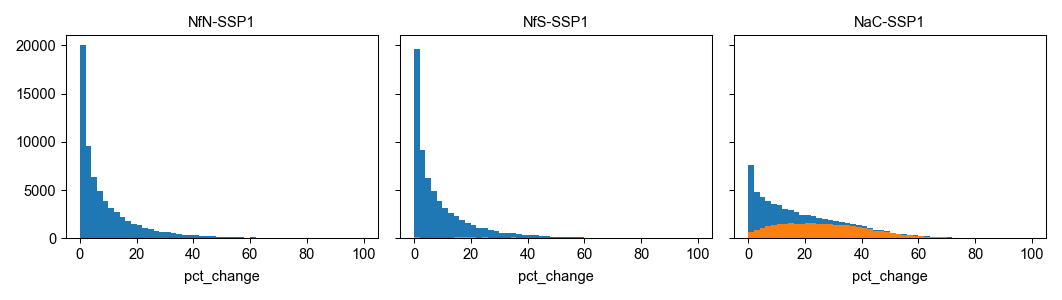

In [32]:
# Strength of PFT perturbation across grid cells and significance of the response
fig, axes = plt.subplots(1,3, figsize=(double_width,2), sharey=True)
for ax, case in zip(axes, ['NfN-SSP1', 'NfS-SSP1', 'NaC-SSP1']):
    change.sel(case=case).plot.hist(ax=ax, bins=50, density=False)
    change.where(sig.T_2M==1).sel(case=case).plot.hist(ax=ax, bins=50, density=False)
    ax.set_title(case)
fig.tight_layout()

In [33]:
# Number of significant grid cells - drivers
file = 'cclm2_seasonal-drivers-sig-change.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file).sel(season='JJA', drop=True)
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file).sel(season='JJA', drop=True)
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file).sel(season='JJA', drop=True)
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file).sel(season='JJA', drop=True)

drv_jja = xr.concat([ds_ssp1,
                     ds_nfn,
                     ds_nfs,
                     ds_nac], dim='case').assign_coords({'case': ('case', ['SSP1-Recent','NfN-SSP1','NfS-SSP1','NaC-SSP1'])})

#table_print = drv_jja.weighted(mask_3D_eu).sum(['lat','lon']).to_array().to_dataset('case').to_dataframe().astype(int)
drv_jja.sum(['lat','lon']).to_array().to_dataset('case').to_dataframe().astype(int)

,SSP1-Recent,NfN-SSP1,NfS-SSP1,NaC-SSP1
variable,,,,
LH,160895,10835,10563,33737
SH,126213,11284,11130,44218
ALBEDO,110288,37593,37132,53875
SWdown,68272,0,0,0
LWdown,147072,0,0,1195


In [34]:
# Number of significant grid cells
table_print = data.weighted(mask_3D_eu).sum(['lat','lon']).to_array().to_dataset('case').to_dataframe().astype(int)
row_headers = ['Annual max air temperature at 2m (TXx, °C)', 'Summer (JJA) air temperature at 2m (°C)', 'Summer (JJA) soil temperature 0-10cm (°C)',
               'Summer (JJA) wind speed at 10m (m s−¹)', 'Summer (JJA) precipitation (mm day−¹)', 'Summer (JJA) soil moisture 0-10cm (mm)', 'Annual GPP (g C m−² day−¹)']
table_print = table_print.rename(index=dict(zip(['TXx', 'T_2M', 'TSOI_10CM', 'WIND_10M', 'PRECIP', 'SOILWATER_10CM', 'GPP'], row_headers)))
table_print

SSP1-Recent  NfN-SSP1  \
variable                                   region                          
Annual max air temperature at 2m (TXx, °C) EU+            9282         0   
                                           North          1487         0   
                                           West           1961         0   
                                           East            263         0   
                                           South          4903         0   
Summer (JJA) air temperature at 2m (°C)    EU+           13812       987   
                                           North          1278         6   
                                           West           2735       767   
                                           East           1778       101   
                                           South          6964        95   
Summer (JJA) soil temperature 0-10cm (°C)  EU+           20702      8327   
                                           North          4253       746   
                                           West           4594      3498   
                                           East           3727      2441   
                                           South          6637      1240   
Summer (JJA) wind speed at 10m (m s−¹)     EU+            2787      5396   
                                           North           410       126   
                                           West             97      2721   
                                           East           1337      2314   
                                           South           811       212   
Summer (JJA) precipitation (mm day−¹)      EU+             434         0   
                                           North            17         0   
                                           West             61         0   
                                           East              1         0   
                                           South           336         0   
Summer (JJA) soil moisture 0-10cm (mm)     EU+            7070      6654   
                                           North           520       185   
                                           West           1003      3194   
                                           East           1868      2134   
                                           South          2963       813   
Annual GPP (g C m−² day−¹)                 EU+           52952     31929   
                                           North         17682      7726   
                                           West          14617     11763   
                                           East          10730      7921   
                                           South          7306      3274   

                                                   NfS-SSP1  NaC-SSP1  
variable                                   region                      
Annual max air temperature at 2m (TXx, °C) EU+            0      4387  
                                           North          0       101  
                                           West           0      2586  
                                           East           0       318  
                                           South          0      1229  
Summer (JJA) air temperature at 2m (°C)    EU+         2438     34533  
                                           North         34      1654  
                                           West        1750     13773  
                                           East         359     11721  
                                           South        194      6204  
Summer (JJA) soil temperature 0-10cm (°C)  EU+         8081     34552  
                                           North        587      2361  
                                           West        3400     13486  
                                           East        2480     11334  
                                           South       1139      6049  
Summer (JJA) w

In [35]:
# Fraction (% area) with significant response
table_print = (100*data.weighted(mask_3D_eu*area.fillna(0)).sum(['lat','lon'])/eunis.weighted(mask_3D_eu*area.fillna(0)).sum(['lat','lon'])).to_array().to_dataset('case').to_dataframe().round(1)
row_headers = ['Annual max air temperature at 2m (TXx, °C)', 'Summer (JJA) air temperature at 2m (°C)', 'Summer (JJA) soil temperature 0-10cm (°C)',
               'Summer (JJA) wind speed at 10m (m s−¹)', 'Summer (JJA) precipitation (mm day−¹)', 'Summer (JJA) soil moisture 0-10cm (mm)', 'Annual GPP (g C m−² day−¹)']
table_print = table_print.rename(index=dict(zip(['TXx', 'T_2M', 'TSOI_10CM', 'WIND_10M', 'PRECIP', 'SOILWATER_10CM', 'GPP'], row_headers)))
table_print.to_excel('Tables/signif-area-fraction.xlsx')
table_print

SSP1-Recent  NfN-SSP1  \
variable                                   region                          
Annual max air temperature at 2m (TXx, °C) EU+            16.0       0.0   
                                           North           8.3       0.0   
                                           West           12.2       0.0   
                                           East            1.6       0.0   
                                           South          49.1       0.0   
Summer (JJA) air temperature at 2m (°C)    EU+            24.0       1.6   
                                           North           5.3       0.0   
                                           West           17.1       4.4   
                                           East           12.0       0.6   
                                           South          69.5       0.9   
Summer (JJA) soil temperature 0-10cm (°C)  EU+            33.9      13.8   
                                           North          22.0       4.0   
                                           West           28.3      21.1   
                                           East           24.0      15.6   
                                           South          66.0      12.2   
Summer (JJA) wind speed at 10m (m s−¹)     EU+             4.5       8.7   
                                           North           2.4       0.6   
                                           West            0.6      16.1   
                                           East            7.6      13.7   
                                           South           8.2       2.1   
Summer (JJA) precipitation (mm day−¹)      EU+             0.8       0.0   
                                           North           0.1       0.0   
                                           West            0.4       0.0   
                                           East            0.0       0.0   
                                           South           3.3       0.0   
Summer (JJA) soil moisture 0-10cm (mm)     EU+            12.4      11.0   
                                           North           2.8       0.9   
                                           West            6.2      18.9   
                                           East           12.0      13.2   
                                           South          29.6       8.2   
Annual GPP (g C m−² day−¹)                 EU+            78.8      48.7   
                                           North          89.6      40.0   
                                           West           87.2      69.8   
                                           East           64.5      47.0   
                                           South          72.4      32.4   

                                                   NfS-SSP1  NaC-SSP1  
variable                                   region                      
Annual max air temperature at 2m (TXx, °C) EU+          0.0       7.3  
                                           North        0.0       0.6  
                                           West         0.0      14.9  
                                           East         0.0       1.9  
                                           South        0.0      12.0  
Summer (JJA) air temperature at 2m (°C)    EU+          3.9      57.8  
                                           North        0.2       9.6  
                                           West        10.0      82.6  
                                           East         2.1      71.6  
                                           South        2.0      61.4  
Summer (JJA) soil temperature 0-10cm (°C)  EU+         13.4      57.2  
                                           North        3.1      13.1  
                                           West        20.4      80.6  
                                           East        15.9      69.2  
                                           South       11.3      60.0  
Summer (JJA) w